# Telco Churn Modelling Dataset
Link to dataset [here](https://www.kaggle.com/blastchar/telco-customer-churn)  
Link to GitHub hosting [here](https://github.com/kartikay-bagla/Telco-Churn-Analysis)  
Link to Kaggle hosting [here](https://www.kaggle.com/drvader/data-viz-churn-prediction-price-regression)  
Link to my blog post of this [here](https://kartikay-bagla.github.io/Telco-Churn-Analysis/)  

A dataset provided by a telecommunications company regarding its customers and whether they stopped using their services or not (churn). I'm using this to explore the data, and practice feature engineering along with classification and regression both.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

pd.set_option("display.max_columns", 100)
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, roc_auc_score, confusion_matrix

## Initially we start with Data Visualization and Exploration

In [2]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

Let's check out the top 5 rows of the data

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Now lets see the datatypes of each column to make sure everything is correctly loaded

In [4]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

Senior citizen should be an object (it will be converted back to onehot in the end though)  
Total charges should be a float/int instead of an object

In [5]:
df.SeniorCitizen.describe()

count    7043.000000
mean        0.162147
std         0.368612
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: SeniorCitizen, dtype: float64

In [6]:
df.SeniorCitizen.replace([0, 1], ["No", "Yes"], inplace= True)

Senior citizen problem fixed, now gotta fix the TotalCharges

In [7]:
df.TotalCharges.describe()

count     7043
unique    6531
top           
freq        11
Name: TotalCharges, dtype: object

In [8]:
df.TotalCharges.unique()

array(['29.85', '1889.5', '108.15', ..., '346.45', '306.6', '6844.5'],
      dtype=object)

In [9]:
for charge in df.TotalCharges:
    try:
        charge = float(charge)
    except:
        print("charge:", charge, "length", len(charge))

charge:   length 1
charge:   length 1
charge:   length 1
charge:   length 1
charge:   length 1
charge:   length 1
charge:   length 1
charge:   length 1
charge:   length 1
charge:   length 1
charge:   length 1


It seems that some charges are blanks. Real smart, guys.

In [10]:
charges = [float(charge) if charge != " " else np.nan for charge in df.TotalCharges]

In [11]:
df.TotalCharges = charges

Now its time to get a feel for the numerical variables

In [12]:
df.describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7032.000000
mean,32.371149,64.761692,2283.300441
std,24.559481,30.090047,2266.771362
min,0.000000,18.250000,18.800000
25%,9.000000,35.500000,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.850000,3794.737500
max,72.000000,118.750000,8684.800000


Same for the categorical variables

In [13]:
df.describe(include=object)

,customerID,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,7043,2,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,2
top,3214-IYUUQ,Male,No,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,No
freq,1,3555,5901,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,5174


Time to plot **HISTOGRAMS**

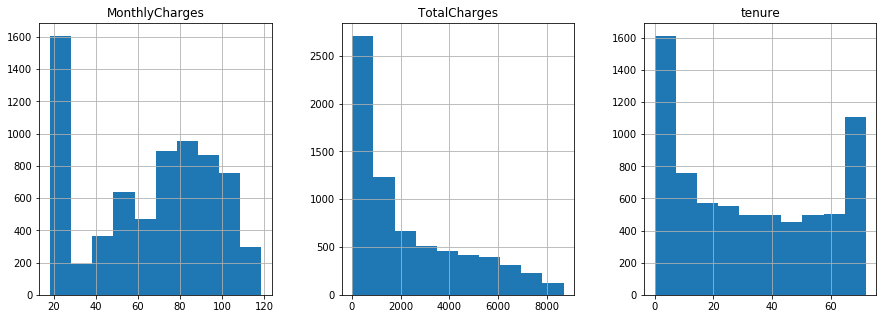

In [14]:
df.hist(figsize=(15, 5), layout=(1, 3))
plt.show()

But what about the categorical variables? We don't want them feeling left out. On to some **COUNTPLOTS!!!**

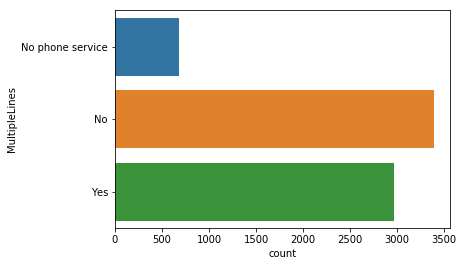

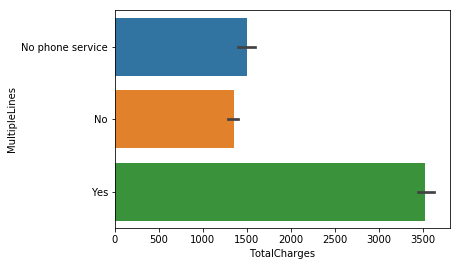

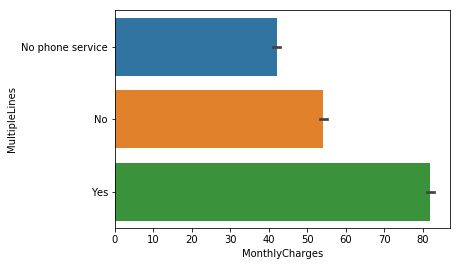

In [15]:
sns.countplot(y="MultipleLines", data= df)
plt.show()
sns.barplot(y="MultipleLines", x="TotalCharges", data= df)
plt.show()
sns.barplot(y="MultipleLines", x="MonthlyCharges", data= df)
plt.show()

Those were all single variable distributions, but what happens when we bring more variables into the game?

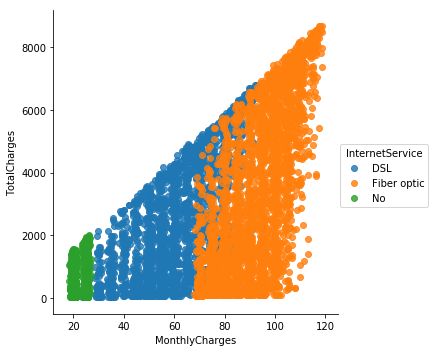

In [16]:
sns.lmplot("MonthlyCharges", "TotalCharges", hue="InternetService", data= df, fit_reg= False)

The graph above has Monthly Charges vs Total Charges where each datapoint is colored by the type of internet service they have

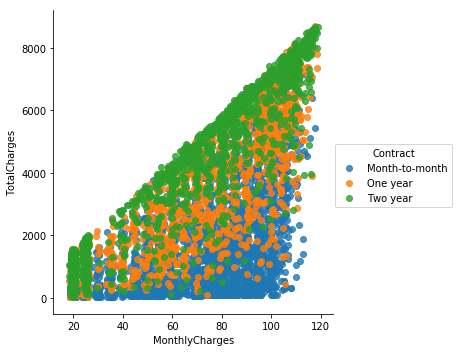

In [17]:
sns.lmplot("MonthlyCharges", "TotalCharges", hue="Contract", data= df, fit_reg= False)

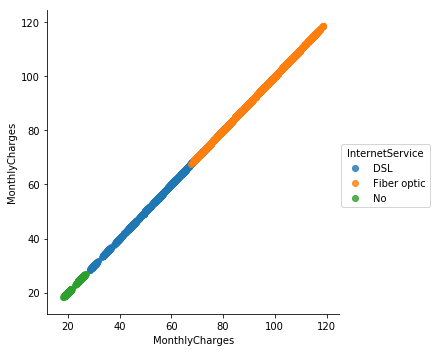

In [18]:
sns.lmplot("MonthlyCharges", "MonthlyCharges", hue="InternetService", data= df, fit_reg= False)

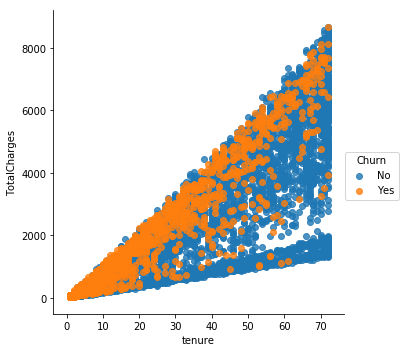

In [19]:
sns.lmplot("tenure", "TotalCharges", data= df, hue="Churn", fit_reg= False)

Now its time to create some **features**

In [20]:
for col in df.dtypes[df.dtypes == object].index:
    print(col, df[col].unique())

customerID ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender ['Female' 'Male']
SeniorCitizen ['No' 'Yes']
Partner ['Yes' 'No']
Dependents ['No' 'Yes']
PhoneService ['No' 'Yes']
MultipleLines ['No phone service' 'No' 'Yes']
InternetService ['DSL' 'Fiber optic' 'No']
OnlineSecurity ['No' 'Yes' 'No internet service']
OnlineBackup ['Yes' 'No' 'No internet service']
DeviceProtection ['No' 'Yes' 'No internet service']
TechSupport ['No' 'Yes' 'No internet service']
StreamingTV ['No' 'Yes' 'No internet service']
StreamingMovies ['No' 'Yes' 'No internet service']
Contract ['Month-to-month' 'One year' 'Two year']
PaperlessBilling ['Yes' 'No']
PaymentMethod ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn ['No' 'Yes']


A ProtectedCustomer is one who has both Online backups and security, similarly I create other features

In [21]:
df["ProtectedCustomer"] = ["Yes" if df.OnlineBackup[i]=="Yes" and df.OnlineSecurity[i]=="Yes" else "No" for i in range(len(df))]

In [22]:
df["StreamerCustomer"] = ["Yes" if df.StreamingMovies[i]=="Yes" and df.StreamingTV[i]=="Yes" else "No" for i in range(len(df))]

In [23]:
df["FamilyCustomer"] = ["Yes" if df.Partner[i]=="Yes" or df.Dependents[i]=="Yes" else "No" for i in range(len(df))]

In [24]:
df["OldFashioned"] = ["Yes" if df.PaperlessBilling[i]=="No" and df.PaymentMethod[i]=="Mailed check" \
                      else "No" for i in range(len(df))]

In [25]:
df["PowerUser"] = ["Yes" if df.ProtectedCustomer[i]=="Yes" and df.StreamerCustomer[i]=="Yes" \
                   and df.DeviceProtection[i]=="Yes" and df.TechSupport[i]=="Yes" else "No" for i in range(len(df))]

In [26]:
df["FamilyMultiple"] = ["Yes" if df.FamilyCustomer[i]=="Yes" and df.MultipleLines[i]=="Yes" else "No" for i in range(len(df))]

In [27]:
df.describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7032.000000
mean,32.371149,64.761692,2283.300441
std,24.559481,30.090047,2266.771362
min,0.000000,18.250000,18.800000
25%,9.000000,35.500000,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.850000,3794.737500
max,72.000000,118.750000,8684.800000


I created another column - FullCharges which is the product of tenure and monthly charges and it closely resembles TotalCharges but differs by plus-minus 200 dollars at the max. Which may be due to excessive services or discounts applied which are not included in the monthly charges

In [28]:
df["FullCharges"] = df.tenure * df.MonthlyCharges

In [29]:
df["Discount"] = df.FullCharges - df.TotalCharges

In [30]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,ProtectedCustomer,StreamerCustomer,FamilyCustomer,OldFashioned,PowerUser,FamilyMultiple,FullCharges,Discount
0,7590-VHVEG,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,No,No,Yes,No,No,No,29.85,0.00
1,5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No,No,No,No,Yes,No,No,1936.30,46.80
2,3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,Yes,No,No,No,No,No,107.70,-0.45
3,7795-CFOCW,Male,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,No,No,No,No,No,No,1903.50,62.75
4,9237-HQITU,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,No,No,No,No,No,No,141.40,-10.25


Checking for missing values

In [31]:
df.isna().sum()

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines         0
InternetService       0
OnlineSecurity        0
OnlineBackup          0
DeviceProtection      0
TechSupport           0
StreamingTV           0
StreamingMovies       0
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges         11
Churn                 0
ProtectedCustomer     0
StreamerCustomer      0
FamilyCustomer        0
OldFashioned          0
PowerUser             0
FamilyMultiple        0
FullCharges           0
Discount             11
dtype: int64

Filling them with the medians

In [32]:
df.TotalCharges.fillna(df.TotalCharges.median(), inplace= True)
df.Discount.fillna(df.Discount.median(), inplace= True)

In [33]:
df.to_csv("cleaned.csv", index= False)

## Now we use the cleaned dataframe for predicting the churn of customers

In [34]:
df = pd.read_csv("cleaned.csv")

In [35]:
df.shape

(7043, 29)

In [36]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,ProtectedCustomer,StreamerCustomer,FamilyCustomer,OldFashioned,PowerUser,FamilyMultiple,FullCharges,Discount
0,7590-VHVEG,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,No,No,Yes,No,No,No,29.85,0.00
1,5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No,No,No,No,Yes,No,No,1936.30,46.80
2,3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,Yes,No,No,No,No,No,107.70,-0.45
3,7795-CFOCW,Male,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,No,No,No,No,No,No,1903.50,62.75
4,9237-HQITU,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,No,No,No,No,No,No,141.40,-10.25


Dropping the customerID as it is of no use to us currently

In [37]:
df.drop("customerID", axis= 1, inplace= True)

Turning Churn into a binary categorical variable

In [38]:
df.Churn.replace(["Yes", "No"], [1, 0], inplace= True)

Turning the database into a one-hot encoded database

In [39]:
df = pd.get_dummies(df)

Initializing X and y

In [40]:
X = df.drop("Churn", axis= 1)
y = df.Churn

### Splitting the dataset

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 1234)

In [42]:
print( len(X_train), len(X_test), len(y_train), len(y_test) )

5634 1409 5634 1409


In [43]:
X_train.shape, y_train.shape

((5634, 60), (5634,))

### Creating Model pipelines

Creating pipelines through which we can feed data

In [44]:
pipelines = {
    "rf": make_pipeline(StandardScaler(), RandomForestClassifier(random_state=123)),
    "gb": make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state=123)),
    "nb": make_pipeline(StandardScaler(), GaussianNB()),
    "kn": make_pipeline(StandardScaler(), KNeighborsClassifier())
}

Getting the list of tunable parameters for the models

In [45]:
pipelines["nb"].get_params()

{'memory': None,
 'steps': [('standardscaler',
   StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('gaussiannb', GaussianNB(priors=None))],
 'standardscaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'gaussiannb': GaussianNB(priors=None),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'gaussiannb__priors': None}

### Hyper parameter grid for all the models

In [46]:
rf_hyperparameters = {
    "randomforestclassifier__n_estimators": [100, 200],
    "randomforestclassifier__max_features": ["auto", "sqrt", 0.33]
}
gb_hyperparameters = {
    "gradientboostingclassifier__n_estimators": [100, 200],
    'gradientboostingclassifier__learning_rate': [0.05, 0.1, 0.2],
    'gradientboostingclassifier__max_depth': [1, 3, 5]
}
kn_hyperparameters = {
    'kneighborsclassifier__n_neighbors': [3, 5, 7, 10]
}
nb_hyperparameters = {
    'gaussiannb__priors': [None]
}
hyperparameters = {"rf": rf_hyperparameters,
                   "gb": gb_hyperparameters,
                   "nb": nb_hyperparameters,
                   "kn": kn_hyperparameters}

### Fitting the models to the training set

In [47]:
fitted_models = {}

for name, pipeline in pipelines.items():
    model = GridSearchCV(pipeline, hyperparameters[name], cv= 10, n_jobs= -1, verbose= 10)
    model.fit(X_train, y_train)
    fitted_models[name] = model
    print(name, 'has been fitted.')

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done  44 out of  60 | elapsed:   11.2s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done  51 out of  60 | elapsed:   13.4s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  58 out of  60 | elapsed:   14.0s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   14.1s finished


rf has been fitted.
Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done 176 out of 180 | elapsed:   41.2s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   41.4s finished


gb has been fitted.
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    1.3s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    1.9s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    2.6s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.5s finished


nb has been fitted.
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done  22 out of  40 | elapsed:   18.1s remaining:   14.8s
[Parallel(n_jobs=-1)]: Done  27 out of  40 | elapsed:   20.1s remaining:    9.6s
[Parallel(n_jobs=-1)]: Done  32 out of  40 | elapsed:   23.4s remaining:    5.8s
[Parallel(n_jobs=-1)]: Done  37 out of  40 | elapsed:   25.6s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   25.8s finished


kn has been fitted.


#### Each model's best r2 score on the training set

In [48]:
for name, model in fitted_models.items():
    print(name, model.best_score_)

rf 0.7983670571529996
gb 0.8102591409300675
nb 0.6975505857294995
kn 0.7806176783812566


#### Each model's scores on the test set

In [49]:
for name, model in fitted_models.items():
    print(name)
    print("-----------")
    pred = model.predict(X_test)
    print('ACC:', accuracy_score(y_test, pred))
    print("ROC:", roc_auc_score(y_test, pred))
    print("CoM:\n", confusion_matrix(y_test, pred))

rf
-----------
ACC: 0.7771469127040455
ROC: 0.6727227954848327
CoM:
 [[929 117]
 [197 166]]
gb
-----------
ACC: 0.794180269694819
ROC: 0.6949878587719714
CoM:
 [[941 105]
 [185 178]]
nb
-----------
ACC: 0.6912704045422285
ROC: 0.7372016708015318
CoM:
 [[672 374]
 [ 61 302]]
kn
-----------
ACC: 0.7735982966643009
ROC: 0.6811255260759868
CoM:
 [[912 134]
 [185 178]]


### Saving the best model

In [50]:
with open('final_model_churn.pkl', 'wb') as f:
    pickle.dump(fitted_models['gb'].best_estimator_, f)

## Now we use regression to predict the total price each customer pays
All of this follows a similar workflow as above!

In [51]:
df = pd.read_csv("cleaned.csv")

In [52]:
df.shape

(7043, 29)

In [53]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,ProtectedCustomer,StreamerCustomer,FamilyCustomer,OldFashioned,PowerUser,FamilyMultiple,FullCharges,Discount
0,7590-VHVEG,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,No,No,Yes,No,No,No,29.85,0.00
1,5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No,No,No,No,Yes,No,No,1936.30,46.80
2,3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,Yes,No,No,No,No,No,107.70,-0.45
3,7795-CFOCW,Male,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,No,No,No,No,No,No,1903.50,62.75
4,9237-HQITU,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,No,No,No,No,No,No,141.40,-10.25


In [54]:
df.drop("customerID", axis= 1, inplace= True)

In [55]:
for col in df.dtypes[df.dtypes==object].index:
    if set(df[col].unique().tolist()) == set(["Yes", "No"]):
        df[col].replace(["Yes", "No"], [1, 0], inplace= True)

In [56]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,ProtectedCustomer,StreamerCustomer,FamilyCustomer,OldFashioned,PowerUser,FamilyMultiple,FullCharges,Discount
0,Female,0,1,0,1,0,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,1,Electronic check,29.85,29.85,0,0,0,1,0,0,0,29.85,0.00
1,Male,0,0,0,34,1,No,DSL,Yes,No,Yes,No,No,No,One year,0,Mailed check,56.95,1889.50,0,0,0,0,1,0,0,1936.30,46.80
2,Male,0,0,0,2,1,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,1,Mailed check,53.85,108.15,1,1,0,0,0,0,0,107.70,-0.45
3,Male,0,0,0,45,0,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,0,Bank transfer (automatic),42.30,1840.75,0,0,0,0,0,0,0,1903.50,62.75
4,Female,0,0,0,2,1,No,Fiber optic,No,No,No,No,No,No,Month-to-month,1,Electronic check,70.70,151.65,1,0,0,0,0,0,0,141.40,-10.25


In [57]:
df.gender.replace(["Male", "Female"], [1, 0], inplace=True)

In [58]:
df = pd.get_dummies(df)

In [59]:
X = df.drop(["TotalCharges", "FullCharges"], axis= 1)
y = df.TotalCharges

### Splitting the dataset

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 1234)

In [61]:
print( len(X_train), len(X_test), len(y_train), len(y_test) )

5634 1409 5634 1409


In [62]:
X_train.shape, y_train.shape

((5634, 47), (5634,))

### Creating Model pipelines

In [63]:
pipelines = {
    "rf": make_pipeline(StandardScaler(), RandomForestRegressor(random_state=123)),
    "gb": make_pipeline(StandardScaler(), GradientBoostingRegressor(random_state=123))
}

### Hyper parameter grid for all the models

In [64]:
rf_hyperparameters = {
    "randomforestregressor__n_estimators": [100, 200],
    "randomforestregressor__max_features": ["auto", "sqrt", 0.33]
}
gb_hyperparameters = {
    "gradientboostingregressor__n_estimators": [100, 200],
    'gradientboostingregressor__learning_rate': [0.05, 0.1, 0.2],
    'gradientboostingregressor__max_depth': [1, 3, 5]
}
hyperparameters = {"rf": rf_hyperparameters,
                   "gb": gb_hyperparameters}

### Fitting the models to the training set

In [65]:
fitted_models = {}

for name, pipeline in pipelines.items():
    model = GridSearchCV(pipeline, hyperparameters[name], cv= 10, n_jobs= -1, verbose= 10)
    model.fit(X_train, y_train)
    fitted_models[name] = model
    print(name, 'has been fitted.')

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done  44 out of  60 | elapsed:   19.1s remaining:    6.9s
[Parallel(n_jobs=-1)]: Done  51 out of  60 | elapsed:   21.8s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done  58 out of  60 | elapsed:   22.5s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   22.6s finished


rf has been fitted.
Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done 176 out of 180 | elapsed:   34.7s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   35.0s finished


gb has been fitted.


#### Each model's best r2 score on the training set

In [66]:
for name, model in fitted_models.items():
    print(name, model.best_score_)

rf 0.9993661675285983
gb 0.9997085932125378


#### Each model's scores on the test set

In [67]:
for name, model in fitted_models.items():
    print(name)
    print("-----------")
    pred = model.predict(X_test)
    print('MAE:', mean_absolute_error(y_test, pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_test, pred)))
    
print("\nMean:", np.mean(y_test))

rf
-----------
MAE: 34.217261710433014
RMSE: 54.09689523940445
gb
-----------
MAE: 25.25727021995152
RMSE: 37.544255793166336

Mean: 2329.957310149043


### Plotting the results

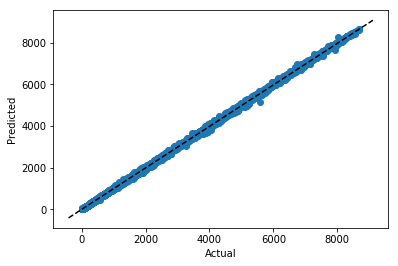

In [68]:
plt.scatter(y, fitted_models["rf"].predict(X))
plt.xlabel("Actual")
plt.ylabel("Predicted")
x_lim = plt.xlim()
y_lim = plt.ylim()
plt.plot(x_lim, y_lim, "k--")
plt.show()

### Saving the best model

In [69]:
with open('final_model_total_price.pkl', 'wb') as f:
    pickle.dump(fitted_models['rf'].best_estimator_, f)

## Monthly bill regression

In [70]:
df = pd.read_csv("cleaned.csv")

In [71]:
df.shape

(7043, 29)

In [72]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,ProtectedCustomer,StreamerCustomer,FamilyCustomer,OldFashioned,PowerUser,FamilyMultiple,FullCharges,Discount
0,7590-VHVEG,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,No,No,Yes,No,No,No,29.85,0.00
1,5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No,No,No,No,Yes,No,No,1936.30,46.80
2,3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,Yes,No,No,No,No,No,107.70,-0.45
3,7795-CFOCW,Male,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,No,No,No,No,No,No,1903.50,62.75
4,9237-HQITU,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,No,No,No,No,No,No,141.40,-10.25


In [73]:
df.drop(["customerID", "FullCharges", "Discount", "TotalCharges"], axis= 1, inplace= True)

In [74]:
for col in df.dtypes[df.dtypes==object].index:
    if set(df[col].unique().tolist()) == set(["Yes", "No"]):
        df[col].replace(["Yes", "No"], [1, 0], inplace= True)

In [75]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn,ProtectedCustomer,StreamerCustomer,FamilyCustomer,OldFashioned,PowerUser,FamilyMultiple
0,Female,0,1,0,1,0,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,1,Electronic check,29.85,0,0,0,1,0,0,0
1,Male,0,0,0,34,1,No,DSL,Yes,No,Yes,No,No,No,One year,0,Mailed check,56.95,0,0,0,0,1,0,0
2,Male,0,0,0,2,1,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,1,Mailed check,53.85,1,1,0,0,0,0,0
3,Male,0,0,0,45,0,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,0,Bank transfer (automatic),42.30,0,0,0,0,0,0,0
4,Female,0,0,0,2,1,No,Fiber optic,No,No,No,No,No,No,Month-to-month,1,Electronic check,70.70,1,0,0,0,0,0,0


In [76]:
df.gender.replace(["Male", "Female"], [1, 0], inplace=True)

In [77]:
df = pd.get_dummies(df)

In [78]:
X = df.drop("MonthlyCharges", axis= 1)
y = df.MonthlyCharges

### Splitting the dataset

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 1234)

In [80]:
print( len(X_train), len(X_test), len(y_train), len(y_test) )

5634 1409 5634 1409


In [81]:
X_train.shape, y_train.shape

((5634, 45), (5634,))

### Creating Model pipelines

In [82]:
pipelines = {
    "rf": make_pipeline(StandardScaler(), RandomForestRegressor(random_state=123)),
    "gb": make_pipeline(StandardScaler(), GradientBoostingRegressor(random_state=123))
}

### Hyper parameter grid for all the models

In [83]:
rf_hyperparameters = {
    "randomforestregressor__n_estimators": [100, 200],
    "randomforestregressor__max_features": ["auto", "sqrt", 0.33]
}
gb_hyperparameters = {
    "gradientboostingregressor__n_estimators": [100, 200],
    'gradientboostingregressor__learning_rate': [0.05, 0.1, 0.2],
    'gradientboostingregressor__max_depth': [1, 3, 5]
}
hyperparameters = {"rf": rf_hyperparameters,
                   "gb": gb_hyperparameters}

### Fitting the models to the training set

In [84]:
fitted_models = {}

for name, pipeline in pipelines.items():
    model = GridSearchCV(pipeline, hyperparameters[name], cv= 10, n_jobs= -1, verbose= 10)
    model.fit(X_train, y_train)
    fitted_models[name] = model
    print(name, 'has been fitted.')

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done  44 out of  60 | elapsed:   14.9s remaining:    5.4s
[Parallel(n_jobs=-1)]: Done  51 out of  60 | elapsed:   16.5s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done  58 out of  60 | elapsed:   17.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   17.5s finished


rf has been fitted.
Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 176 out of 180 | elapsed:   31.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   31.4s finished


gb has been fitted.


#### Each model's best r2 score on the training set

In [85]:
for name, model in fitted_models.items():
    print(name, model.best_score_)

rf 0.9981373482535749
gb 0.9988541855918313


#### Each model's scores on the test set

In [86]:
for name, model in fitted_models.items():
    print(name)
    print("-----------")
    pred = model.predict(X_test)
    print('MAE:', mean_absolute_error(y_test, pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_test, pred)))
    
print("\nMean:", np.mean(y_test))

rf
-----------
MAE: 0.9776465016871156
RMSE: 1.3108129109376256
gb
-----------
MAE: 0.8138767741508626
RMSE: 1.064820414947185

Mean: 65.23381831085878


### Plotting the results

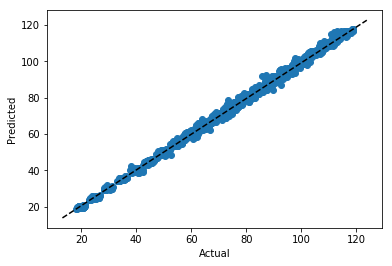

In [87]:
plt.scatter(y, fitted_models["rf"].predict(X))
plt.xlabel("Actual")
plt.ylabel("Predicted")
x_lim = plt.xlim()
y_lim = plt.ylim()
plt.plot(x_lim, y_lim, "k--")
plt.show()

### Saving the best model

In [88]:
with open('final_model_monthly_price.pkl', 'wb') as f:
    pickle.dump(fitted_models['rf'].best_estimator_, f)

# Finished!